In [74]:
import matplotlib.font_manager as font_manager
from descartes import PolygonPatch
from time import time
import alphashape
import seaborn as sns
from shapely.ops import cascaded_union, polygonize, unary_union
from shapely.geometry import LinearRing
from shapely.geometry import Point, MultiPoint
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
from geopandas import GeoSeries
import numpy as np
import os
import pandas as pd
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import csv
from shapely import LineString
import pickle
from collections import Counter
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import networkx as nx
# from contextily import add_basemap
from libpysal import weights
from descartes import PolygonPatch
from time import time
import alphashape
import seaborn as sns
from shapely.ops import cascaded_union, polygonize, unary_union

fontsize = 20
# fontsize_ax_ticks = 25
# fontsize_legend = 25
figsize = (15, 10)
font = 'Times New Roman'

resultpath = 'results/'
network_polygon = '../../data/network/QGIS_Project/referentiel-comptages-edit.shp'

# path_to_cycling_ways = '../../data/cycleways_2000-2022.geojson'
# df_car_detectors = gpd.read_file(
#     '../../data/all_car_detectors.geojson')
# bike_detectors = gpd.read_file('../../data/all_bike_detectors.geojson')

# paris_district_shapefile = '../../data/districts_shapefile/arrondissements.shp'

def get_exterior_coords(df, start_point, end_point):
    filtered_gdf = df[(df["c_ar"] >= start_point) & (df["c_ar"] <= end_point)]

    # Check if there are any polygons matching the condition
    if not filtered_gdf.empty:
        # Apply unary_union to combine the selected polygons into a single polygon
        districts_polygon = unary_union(filtered_gdf["geometry"])
    else:
        # If no polygons match the condition, union_polygon will be None
        districts_polygon = None

    return districts_polygon.exterior.coords.xy

In [2]:

qgis_road_network = gpd.read_file(network_polygon)
qgis_road_network.crs = "EPSG:4326"
alpha_shape = alphashape.alphashape(qgis_road_network, 435)
coordinates = list(alpha_shape.exterior[0].coords)
polygon = Polygon(coordinates)
x_coords, y_coords = zip(*coordinates)

In [3]:
paris_districts = gpd.read_file('../../data/districts_paris.geojson')

polygon_all_districts = paris_districts.unary_union

In [44]:
# get OSM dataframe

ox.settings.log_console = True
G_road_network = ox.graph_from_polygon(
    polygon_all_districts, simplify=True, network_type="drive")
nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)
df_osm['osm_id'] = range(1, len(df_osm) + 1)

ox.settings.log_console = True
G_bike_network = ox.graph_from_polygon(
    polygon_all_districts, simplify=True, network_type="bike")
nodes_osm, df_osm_bike = momepy.nx_to_gdf(G_bike_network, points=True, lines=True)
df_osm_bike['osm_id'] = range(1, len(df_osm_bike) + 1)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_45536/427811016.py:6: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes_osm, df_osm = momepy.nx_to_gdf(G_road_network, points=True, lines=True)


In [30]:
x_district_1_4, y_district_1_4  = get_exterior_coords(paris_districts, 1, 4)
x_district_5_7, y_district_5_7  = get_exterior_coords(paris_districts, 5, 7)

/var/folders/m_/fjnjc1sn0ggc7z_2y7n27xfh0000gn/T/ipykernel_45536/3320330520.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):


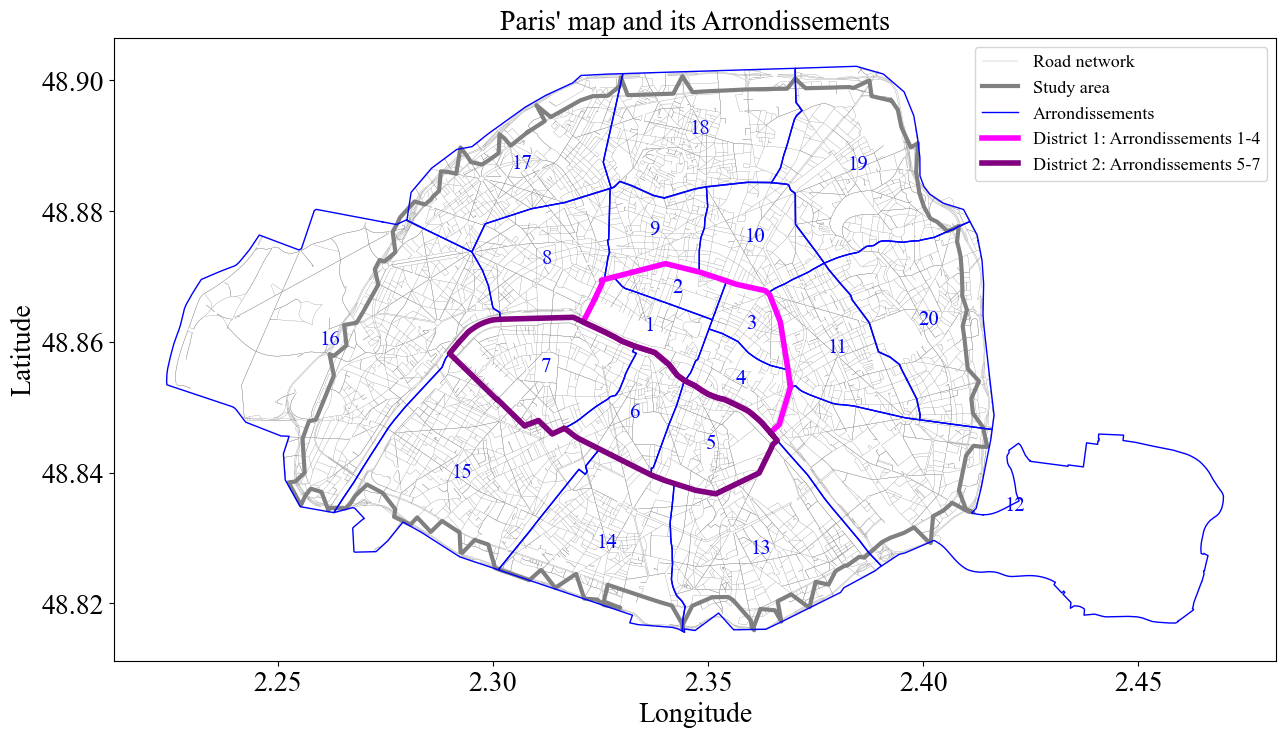

In [79]:
# plot the shapefile, and label the districts with the value in the column "l_ar"
fig, ax = plt.subplots(figsize=figsize)
ax.set_title('Paris\' map and its Arrondissements', font = font, fontsize = fontsize)

# df_osm_bike.plot(ax = ax, color = "grey", linewidth = 0.2, label = 'Network')

# paris_districts.plot(column='c_ar', ax=ax, legend=False, alpha = 0.1, edgecolor='black', linewidth = 5)
df_osm.plot(ax = ax, color = "grey", linewidth = 0.2, label = "Road network")
ax.plot(x_coords, y_coords, color='grey', linewidth=3, label='Study area')

for idx, row in paris_districts.iterrows():
    # Plot each polygon
    x, y = row['geometry'].exterior.xy
    # plt.plot(x, y, color = "blue", linewidth = 1)
    if idx == 0:
        plt.plot(x, y, color = "blue", linewidth = 1, label = 'Arrondissements')
    else: 
        plt.plot(x, y, color = "blue", linewidth = 1)

plt.plot(x_district_1_4, y_district_1_4, color = 'magenta', linewidth = 4, label = 'District 1: Arrondissements 1-4')
plt.plot(x_district_5_7, y_district_5_7, color = 'purple', linewidth = 4, label = 'District 2: Arrondissements 5-7')

for x, y, label in zip(paris_districts.geometry.centroid.x, paris_districts.geometry.centroid.y, paris_districts.c_ar):
    ax.text(x, y, label, color = 'blue', fontsize=15, font = font, ha='center', va='center') 
plt.xticks(font = font, fontsize = fontsize)
plt.yticks(font = font, fontsize = fontsize)
plt.xlabel("Longitude", font = font, fontsize = fontsize)
plt.ylabel("Latitude", font = font, fontsize = fontsize)
font_legend = font_manager.FontProperties(family=font, style='normal', size=13)
plt.legend(loc='upper right', prop = font_legend)
plt.savefig(resultpath + 'paris_districts.pdf', dpi = 1200, bbox_inches = 'tight')